# STEP 1: Setup and Installation

In [ ]:
# Install required packages
!pip install ultralytics -q
!pip install roboflow -q

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import os
import shutil
import yaml
from pathlib import Path
from ultralytics import YOLO
import cv2
from IPython.display import Image, display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 126.4 MB/s eta 0:00:00
Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# STEP 2: Dataset Preparation

In [ ]:
# Set your Google Drive path where you uploaded the dataset
DATASET_PATH = '/content/drive/MyDrive/kaggle/input/face-detection'

# Create working directory
WORK_DIR = '/content/face_detection_yolo'
os.makedirs(WORK_DIR, exist_ok=True)
os.chdir(WORK_DIR)

# Copy dataset from Drive to Colab (faster training)
print("Copying dataset from Drive to Colab...")
if os.path.exists(DATASET_PATH):
    shutil.copytree(DATASET_PATH, f'{WORK_DIR}/dataset', dirs_exist_ok=True)
    print("Dataset copied successfully!")
else:
    print(f"Dataset not found at {DATASET_PATH}. Please check the path.")

Copying dataset from Drive to Colab...
Dataset copied successfully!


# STEP 3: Convert CSV Annotations to YOLO Format


In [ ]:
"""
This dataset has:
- train/, valid/, test/ folders with images
- _annotations.csv in each folder with bbox coordinates
- CSV format: filename, width, height, class, xmin, ymin, xmax, ymax

YOLO format needs:
- class x_center y_center width height (all normalized 0-1)
"""

import pandas as pd

def csv_to_yolo_format(xmin, ymin, xmax, ymax, img_width, img_height):
    """
    Convert CSV bbox (xmin, ymin, xmax, ymax) to YOLO format
    YOLO format: class x_center y_center width height (normalized)
    """
    # Calculate center coordinates and dimensions
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    width = xmax - xmin
    height = ymax - ymin

    # Normalize by image dimensions
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height

    return x_center, y_center, width, height

def convert_dataset_to_yolo():
    """
    Convert the face detection dataset to YOLO format
    """
    # Create directory structure
    dirs = ['images/train', 'images/val', 'images/test',
            'labels/train', 'labels/val', 'labels/test']
    for d in dirs:
        os.makedirs(f'{WORK_DIR}/{d}', exist_ok=True)

    # Process each split (train, valid, test)
    splits = {
        'train': 'train',
        'valid': 'val',  # Rename 'valid' to 'val' for YOLO
        'test': 'test'
    }

    for source_split, target_split in splits.items():
        source_dir = f'{WORK_DIR}/dataset/{source_split}/{source_split}'
        csv_path = f'{source_dir}/_annotations.csv'

        if not os.path.exists(csv_path):
            print(f"⚠️ Warning: {csv_path} not found, skipping {source_split}")
            continue

        print(f"\nProcessing {source_split} split...")

        # Read CSV annotations
        df = pd.read_csv(csv_path)
        print(f"  Found {len(df)} annotations for {df['filename'].nunique()} images")

        # Group by filename (multiple faces per image)
        grouped = df.groupby('filename')

        processed_images = 0
        processed_annotations = 0

        for filename, group in grouped:
            # Copy image
            src_img = f'{source_dir}/{filename}'
            dst_img = f'{WORK_DIR}/images/{target_split}/{filename}'

            if os.path.exists(src_img):
                shutil.copy(src_img, dst_img)
                processed_images += 1

                # Create YOLO label file
                label_filename = os.path.splitext(filename)[0] + '.txt'
                label_path = f'{WORK_DIR}/labels/{target_split}/{label_filename}'

                with open(label_path, 'w') as f:
                    for _, row in group.iterrows():
                        # Convert to YOLO format
                        x_center, y_center, width, height = csv_to_yolo_format(
                            row['xmin'], row['ymin'], row['xmax'], row['ymax'],
                            row['width'], row['height']
                        )

                        # Write: class_id x_center y_center width height
                        # class_id = 0 for face (single class)
                        f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                        processed_annotations += 1
            else:
                print(f"  ⚠️ Image not found: {filename}")

        print(f"  ✓ Processed {processed_images} images with {processed_annotations} face annotations")

    print("\n" + "="*60)
    print("Dataset conversion complete!")
    print("="*60)

# Run conversion
convert_dataset_to_yolo()


Processing train split...
  Found 2316 annotations for 1121 images
  ✓ Processed 1121 images with 2316 face annotations

Processing valid split...
  Found 49 annotations for 37 images
  ✓ Processed 37 images with 49 face annotations

Processing test split...
  Found 263 annotations for 136 images
  ✓ Processed 136 images with 263 face annotations

Dataset conversion complete!


# STEP 5: Create data.yaml Configuration File


In [ ]:
data_yaml = {
    'path': WORK_DIR,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',  # Added test set
    'nc': 1,  # number of classes
    'names': ['face']  # class names
}

with open(f'{WORK_DIR}/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("\ndata.yaml created:")
print(yaml.dump(data_yaml, default_flow_style=False))


data.yaml created:
names:
- face
nc: 1
path: /content/face_detection_yolo
test: images/test
train: images/train
val: images/val



# STEP 6: Verify Dataset


In [ ]:

def verify_dataset():
    """Check dataset integrity"""
    train_images = len(os.listdir(f'{WORK_DIR}/images/train'))
    train_labels = len(os.listdir(f'{WORK_DIR}/labels/train'))
    val_images = len(os.listdir(f'{WORK_DIR}/images/val'))
    val_labels = len(os.listdir(f'{WORK_DIR}/labels/val'))
    test_images = len(os.listdir(f'{WORK_DIR}/images/test'))
    test_labels = len(os.listdir(f'{WORK_DIR}/labels/test'))

    print("\nDataset Summary:")
    print(f"Train - Images: {train_images}, Labels: {train_labels}")
    print(f"Val   - Images: {val_images}, Labels: {val_labels}")
    print(f"Test  - Images: {test_images}, Labels: {test_labels}")

    # Sample a label file to verify format
    if train_labels > 0:
        sample_label = os.listdir(f'{WORK_DIR}/labels/train')[0]
        print(f"\nSample label file ({sample_label}):")
        with open(f'{WORK_DIR}/labels/train/{sample_label}', 'r') as f:
            lines = f.readlines()[:3]  # Show first 3 annotations
            for line in lines:
                print(f"  {line.strip()}")
            if len(f.readlines()) > 3:
                print(f"  ... and more")

    if train_images == 0 or val_images == 0:
        print("\n⚠️ WARNING: No images found! Please check dataset organization.")
    elif train_images != train_labels or val_images != val_labels:
        print("\n⚠️ WARNING: Mismatch between images and labels!")
    else:
        print("\n✓ Dataset looks good!")

verify_dataset()


Dataset Summary:
Train - Images: 1121, Labels: 1121
Val   - Images: 37, Labels: 37
Test  - Images: 136, Labels: 136

Sample label file (IMG_4921-2_mp4-15_jpg.rf.32c179aa6956e1d0188c06a45bb0b88c.txt):
  0 0.329167 0.505469 0.434259 0.351562

✓ Dataset looks good!


# STEP 7: Initialize YOLOv11 Model


In [ ]:
# Load a pretrained YOLOv11 model (nano, small, medium, large, or extra-large)
model = YOLO('yolo11n.pt')  # 'n' for nano (fastest), 's', 'm', 'l', 'x' for larger models

print("\nModel loaded successfully!")


Model loaded successfully!


# STEP 8: Train the Model


In [ ]:
print("\nStarting training...")

# Training parameters
results = model.train(
    data=f'{WORK_DIR}/data.yaml',
    epochs=10,                # Number of training epochs
    imgsz=640,                 # Image size
    batch=16,                  # Batch size (reduce if out of memory)
    device=0,                  # Use GPU 0
    workers=2,                 # Number of workers
    project='face_detection',  # Project name
    name='yolov11_face',       # Experiment name
    patience=20,               # Early stopping patience
    save=True,                 # Save checkpoints
    plots=True,                # Create plots
    # Augmentation parameters
    hsv_h=0.015,              # HSV-Hue augmentation
    hsv_s=0.7,                # HSV-Saturation augmentation
    hsv_v=0.4,                # HSV-Value augmentation
    degrees=0.0,              # Rotation (+/- deg)
    translate=0.1,            # Translation (+/- fraction)
    scale=0.5,                # Scale (+/- gain)
    flipud=0.0,               # Flip up-down probability
    fliplr=0.5,               # Flip left-right probability
    mosaic=1.0,               # Mosaic augmentation probability
)

print("\nTraining complete!")


Starting training...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/face_detection_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_face2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20,

# STEP 9: Evaluate the Model


In [ ]:
# Load the best model
best_model = YOLO('face_detection/yolov11_face/weights/best.pt')

# Validate
metrics = best_model.val()

print("\nValidation Metrics:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3242.9±921.3 MB/s, size: 99.9 KB)
val: Scanning /content/face_detection_yolo/labels/val.cache... 37 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 37/37 72.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.2it/s 2.5s
                   all         37         49      0.977      0.853      0.932      0.527
Speed: 10.9ms preprocess, 20.4ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to /content/face_detection_yolo/runs/detect/val

Validation Metrics:
mAP50: 0.9321
mAP50-95: 0.5274
Precision: 0.9766
Recall: 0.8533


# STEP 10: Test on Sample Images



Running inference on sample images...

image 1/1 /content/face_detection_yolo/images/val/Movie-on-2-18-25-at-8_25-PM_mov-0033_jpg.rf.2a10283d8005fd155a6244c2073723aa.jpg: 448x640 2 faces, 15.9ms
Speed: 4.9ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


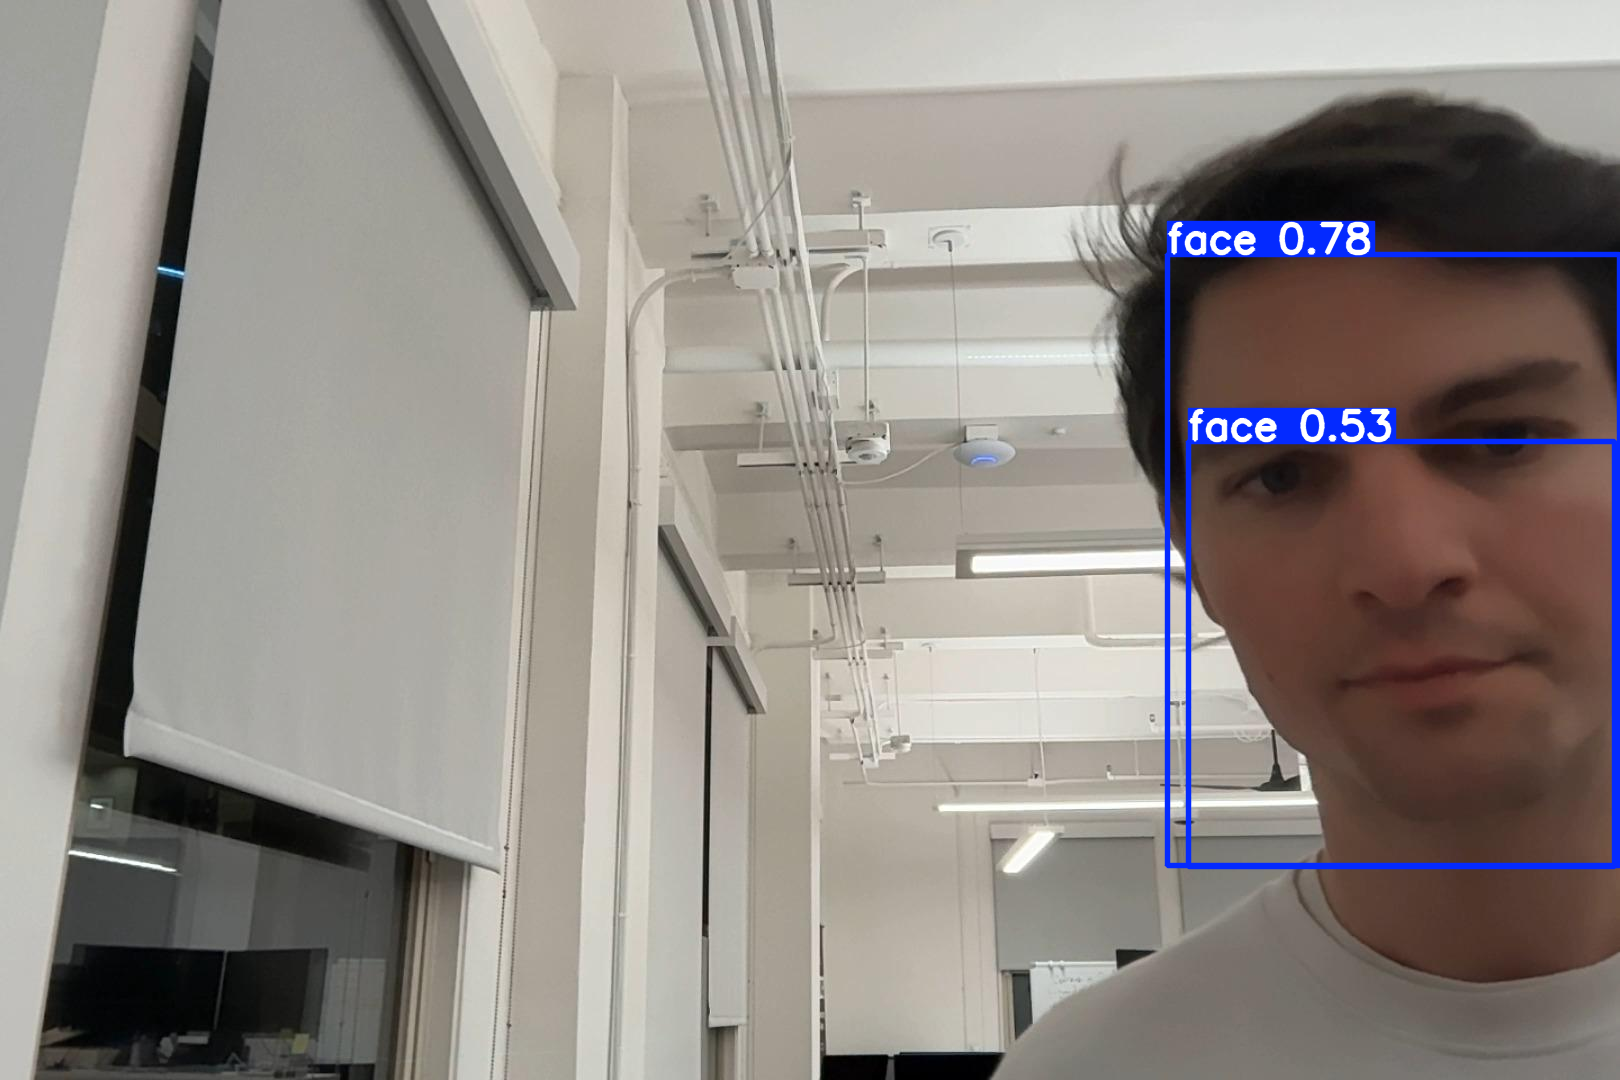


image 1/1 /content/face_detection_yolo/images/val/Movie-on-2-18-25-at-8_25-PM_mov-0109_jpg.rf.fde3efe7563015a7a11538b0402d15e7.jpg: 448x640 1 face, 13.1ms
Speed: 3.6ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


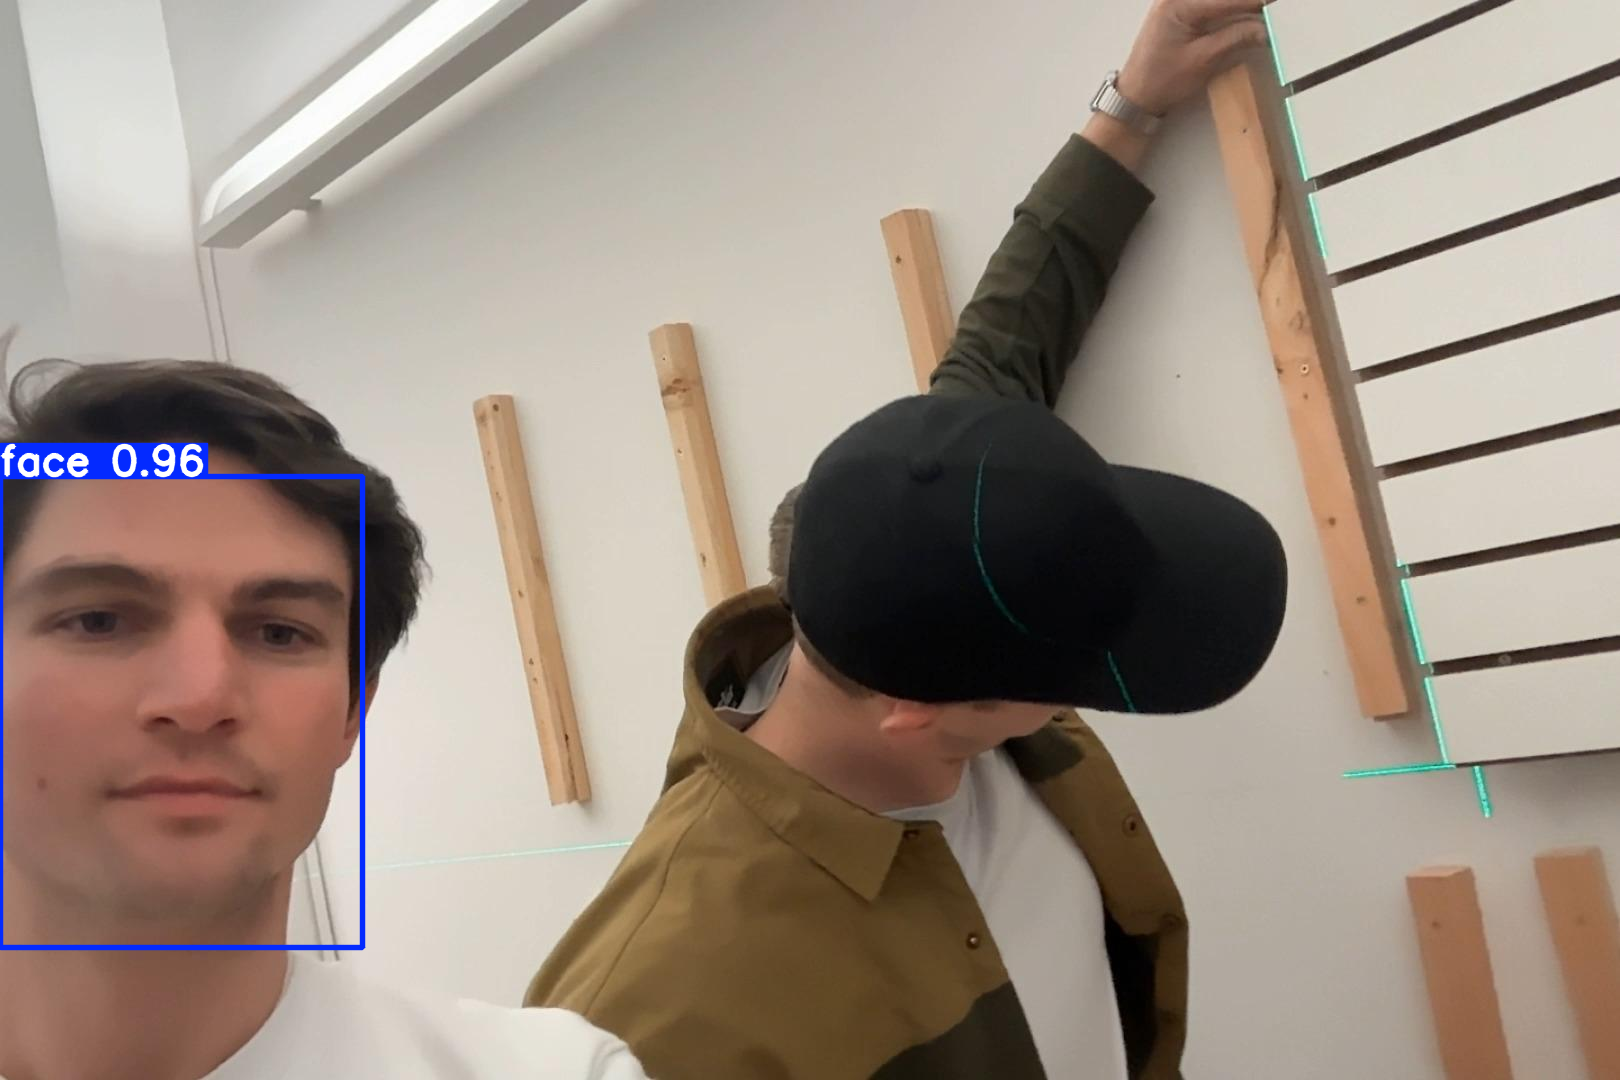


image 1/1 /content/face_detection_yolo/images/val/Movie-on-2-18-25-at-8_25-PM_mov-0054_jpg.rf.34edda9d580d869bbf8199596dadd224.jpg: 448x640 3 faces, 12.5ms
Speed: 3.7ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


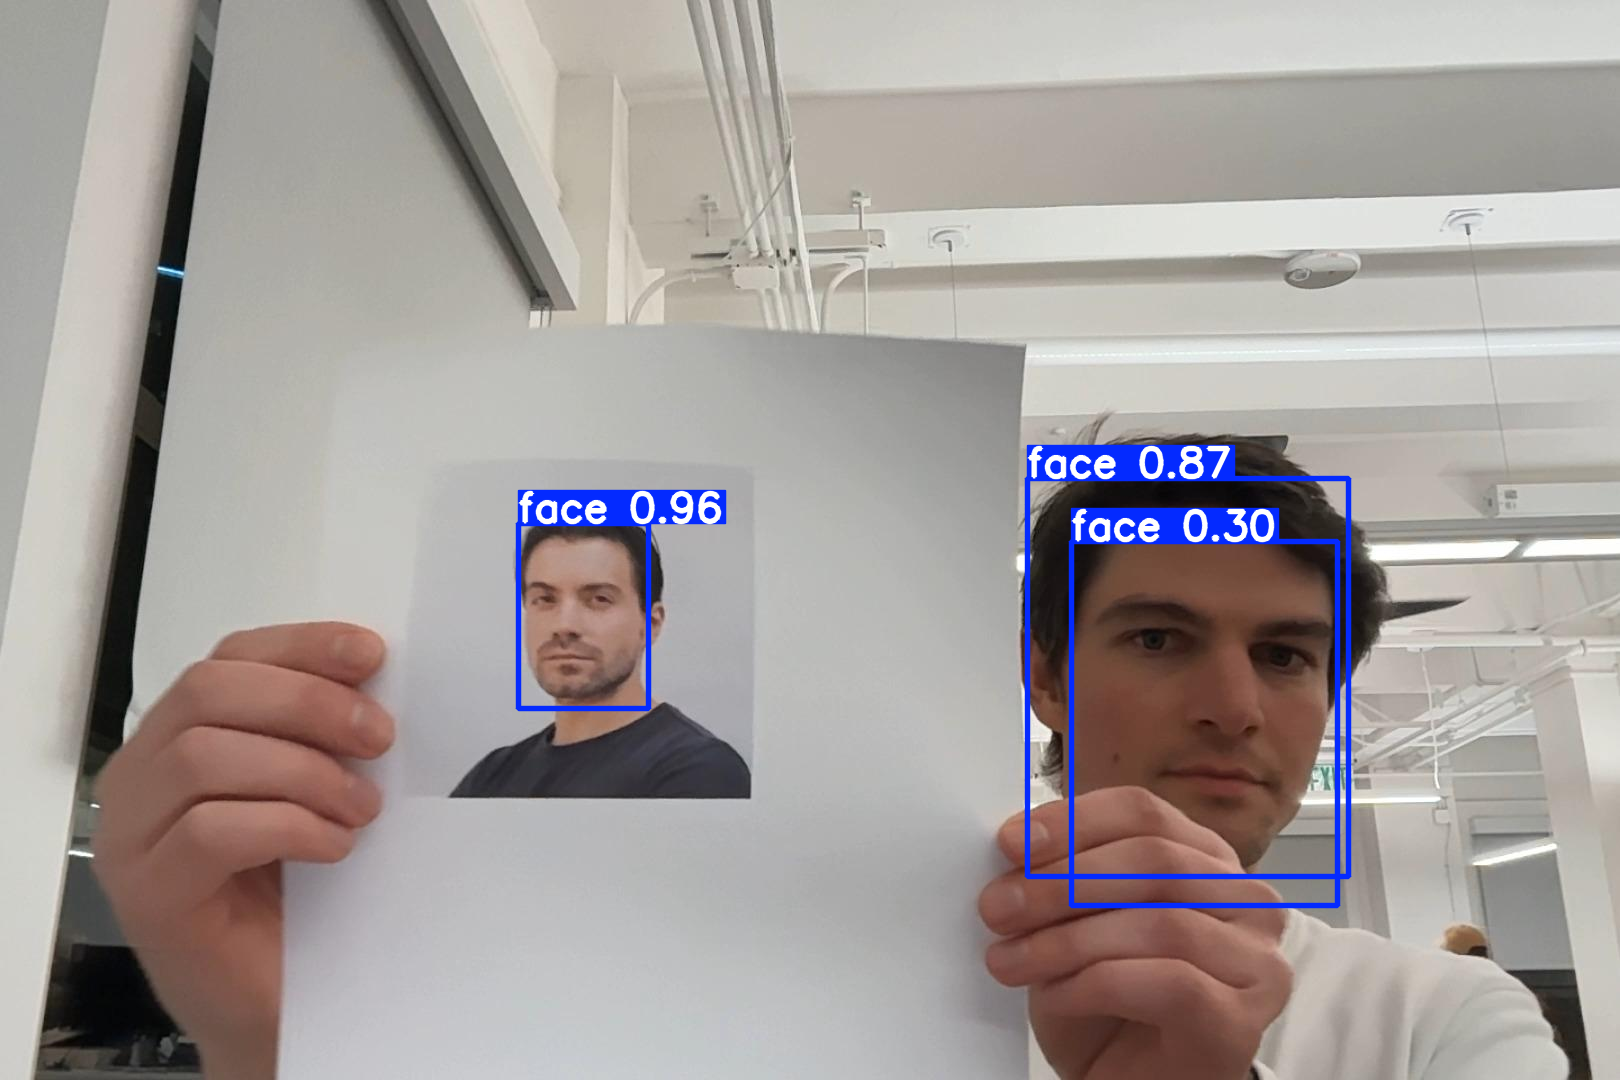


image 1/1 /content/face_detection_yolo/images/val/Movie-on-2-18-25-at-8_25-PM_mov-0051_jpg.rf.582d00c9cb33b6ed173479a555902168.jpg: 448x640 4 faces, 11.8ms
Speed: 4.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


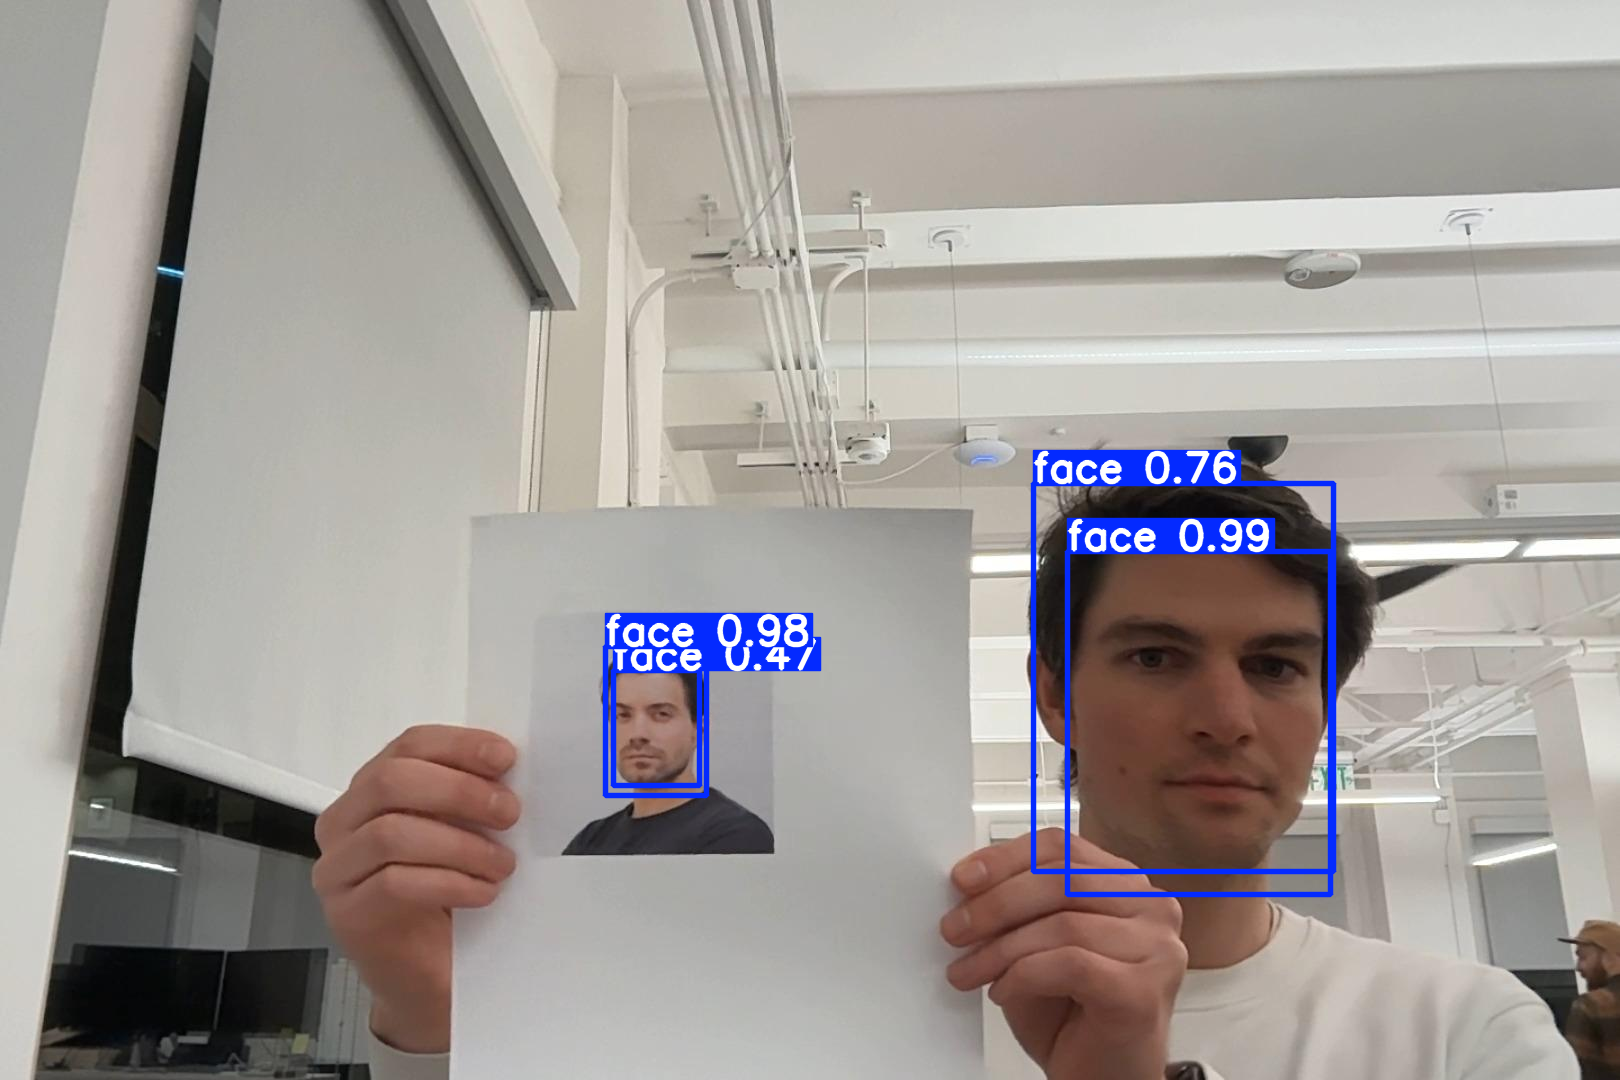


image 1/1 /content/face_detection_yolo/images/val/Movie-on-2-18-25-at-8_25-PM_mov-0041_jpg.rf.b015471833cd10a7d2c982b28d044408.jpg: 448x640 2 faces, 11.3ms
Speed: 3.7ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


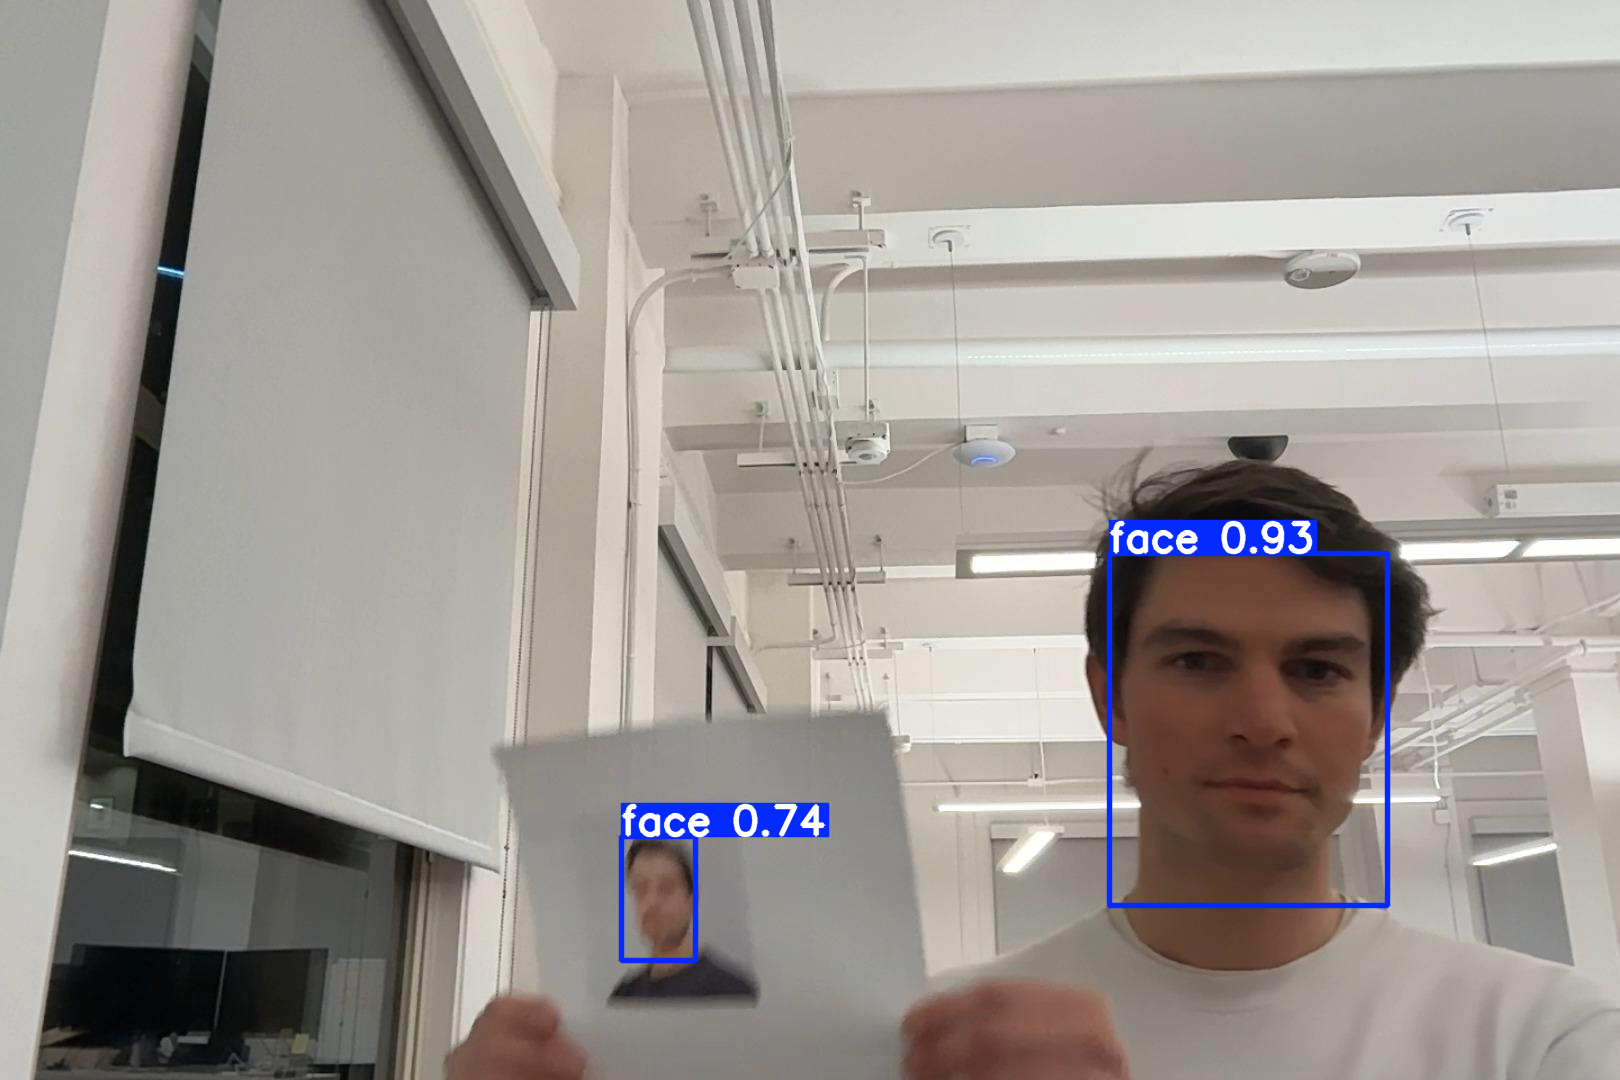

In [ ]:
# Test on validation images
import glob
from PIL import Image as PILImage

val_images = glob.glob(f'{WORK_DIR}/images/val/*.jpg')[:5]

print("\nRunning inference on sample images...")

for img_path in val_images:
    results = best_model(img_path)

    # Display results
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = PILImage.fromarray(im_array[..., ::-1])  # RGB PIL image
        display(im)

# STEP 11: Export Model


In [ ]:
# Export to different formats
print("\nExporting model...")

# Export to ONNX (for deployment)
best_model.export(format='onnx')

# Export to TensorRT (for NVIDIA devices)
# best_model.export(format='engine')

# Export to TFLite (for mobile)
# best_model.export(format='tflite')

print("\n✓ Model exported successfully!")

# STEP 12: Save Model to Google Drive


In [ ]:
# Copy best model to Google Drive
output_dir = '/content/drive/MyDrive/yolov11_face_model'
os.makedirs(output_dir, exist_ok=True)

shutil.copy('face_detection/yolov11_face/weights/best.pt',
            f'{output_dir}/best.pt')
shutil.copy('face_detection/yolov11_face/weights/last.pt',
            f'{output_dir}/last.pt')

print(f"\n✓ Models saved to: {output_dir}")